**Problem**

Cookie Cats is a popular mobile puzzle game developed by Tactile Entertainment. Players must connect tiles of the same color to clear the board and progress through levels. The game features singing cats. As players advance, they encounter gates that require waiting or making in-app purchases to continue.

These gates serve the purpose of encouraging purchases and providing players with breaks to enhance enjoyment. The initial gate was placed at level 30. In this project, I're going to analyze an AB-test where we moved the first gate in Cookie Cats from `level 30` to `level 40`. In particular, we will look at the impact on player retention


dataset: https://www.kaggle.com/dfsets/yufengsui/mobile-games-ab-testing

**About dataset**

The dataset is from 90,189 players that installed the game while the AB-test was running. The variables are:

* `userid` - a unique number that identifies each player.
* `version` - whether the player was put in the control group (gate_30 - a gate at level 30) or the test group (gate_40 - a gate at level 40).
* `sum_gamerounds` - the number of game rounds played by the player during the first week after installation
* `retention_1` - did the player come back and play 1 day after installing?
* `retention_7` - did the player come back and play 7 days after installing?
* When a player installed the game, he or she was randomly assigned to either `gate_30` or `gate_40`


In [74]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import libraries

In [75]:
import os
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [76]:
root_dir = '/content/drive/My Drive/'
path = os.path.join(root_dir, 'projects', 'dataset','cookie_cats.csv')
df = pd.read_csv(path)
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [77]:
df.shape

(90189, 5)

In [78]:
def check_null_columns(df):
    null_columns = df.columns[df.isnull().any()]
    return null_columns
null_cols = check_null_columns(df)
null_cols

Index([], dtype='object')

Split group: control group & treatment group

In [79]:
group_A = df[df['version']=='gate_30']  #control group: gate_30
group_B = df[df['version']=='gate_40']  #Treatment group: gate_40
print('Control group gate_30: \n', group_A.head())
print('Treatment group gate_40: \n', group_B.head())

Control group gate_30: 
     userid  version  sum_gamerounds  retention_1  retention_7
0      116  gate_30               3        False        False
1      337  gate_30              38         True        False
6     1066  gate_30               0        False        False
11    2101  gate_30               0        False        False
13    2179  gate_30              39         True        False
Treatment group gate_40: 
    userid  version  sum_gamerounds  retention_1  retention_7
2     377  gate_40             165         True        False
3     483  gate_40               1        False        False
4     488  gate_40             179         True         True
5     540  gate_40             187         True         True
7    1444  gate_40               2        False        False


In [80]:
# Calculating 1-day and 7-days retention for each A/B group
group = df.groupby('version').agg({'userid':'count','sum_gamerounds':'mean','retention_1':'mean', 'retention_7':'mean'})
group

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,52.456264,0.448188,0.190201
gate_40,45489,51.298776,0.442283,0.182000


### The Hypotheses Testing using **Metric**:  `1-day Retention ratio`

### The Hypotheses

$H_0: \text{There is no significant difference between the retention ratio of gate_30 and gate_40 } (p_A = p_B$)

$H_1: \text{There is a significant difference between the retention ratio of gate_30 and gate_40 }(p_A \neq p_B$)


In [81]:
# prepare data for 1 day retention
# sample size
n_A = len(df[df['version'] == 'gate_30'])
n_B = len(df[df['version'] == 'gate_40'])

# retention_1 = true for A, B
x_A = len(df[(df['version'] == 'gate_30') & (df['retention_1'] == True)])
x_B = len(df[(df['version'] == 'gate_40') & (df['retention_1'] == True)])

# Tỉ lệ retention_1
p_A_hat = x_A / n_A # p_A_hat = group['retention_1']['gate_30']
p_B_hat = x_B / n_B # p_B_hat = group['retention_1']['gate_40']

# save to df
table = pd.DataFrame({
    'Retention_1_Yes': [x_A, x_B],
    'sample_size': [n_A, n_B],
    'Retention_rate': [p_A_hat, p_B_hat]},
    index=['A', 'B'])

table


,Retention_1_Yes,sample_size,Retention_rate
A,20034,44700,0.448188
B,20119,45489,0.442283


In [82]:
# Testing
from scipy.stats import norm
import math
# Under H0: Z_statistic ~ N(0,1)
def check_condition(p_hat, n_A, n_B):
    if (n_A*p_hat < 10) | (n_A*(1-p_hat)<10) | (n_B*p_hat < 10) | (n_B*(1-p_hat)<10):
        print('The sample size < 10. Consider collecting more data !')
    else:
        print('Continue !')

# function for testing
def z_test_proportions(x_A, x_B, n_A, n_B, alpha = 0.05):
    pooled_p = (x_A + x_B)/(n_A + n_B)
    # check condition
    check_condition(pooled_p, n_A, n_B)
    # calculate
    critical_z_score= norm.ppf(alpha)
    d = p_A_hat - p_B_hat
    se = math.sqrt(pooled_p*(1 - pooled_p)*(1/n_A + 1/n_B)) # SE for testing H0: p_A = p_B
    observed_z = d/se
    # p_value = norm().cdf(z_statistic) # --> 1 tail
    p_value = 2 * (1 - norm.cdf(abs(observed_z)))

    # Conclusion
    # for p value
    if p_value < alpha:
        conclusion_p_value = 'Reject the null hypothesis' # Có sự khác biệt đáng kể giữa hai nhóm
    else:
        conclusion_p_value = 'Insufficient evidence to reject H0'
    # for z_statistic
    # abs_z_statistic = abs(z_statistic)
    if observed_z < critical_z_score:
        conclusion_z = 'Reject the null hypothesis'
    else:
        conclusion_z = 'Insufficient evidence to reject H0'
    # save to dataframe
    summary_result = pd.DataFrame(
        {
            'p_value': p_value,
            'alpha': alpha,
            'conclusion_p_value': conclusion_p_value,
            'observed_z': observed_z,
            'critical_z_score': critical_z_score,
            'conclusion_z': conclusion_z
        }, index = ['Conclusion']
    )

    return summary_result

result_1day = z_test_proportions(x_A, x_B, n_A, n_B, alpha = 0.05)
result_1day


Continue !


,p_value,alpha,conclusion_p_value,observed_z,critical_z_score,conclusion_z
Conclusion,0.07441,0.05,Insufficient evidence to reject H0,1.784086,-1.644854,Insufficient evidence to reject H0


**Conclusion**

With the above result, `p-value = 0.07441` > $\alpha=0.05$, so we do not have enough evidence to reject $H_0$.

 It means there is no significant difference in the customer retention rate between `version A (gate_30)` and `B (gate_40)`.

### The Hypotheses Testing using **Metric**:  `mean of sum_gamerounds`

### The Hypotheses

$H_0: \text{There is no significant difference between mean sum_gamerounds of gate_30 and gate_40 } (\mu_A = \mu_B$)

$H_1: \text{There is a significant difference between mean sum_gamerounds of gate_30 and gate_40 }(\mu_A \neq \mu_B$)


In [83]:
# prepare data
data_A = df[df['version']=='gate_30']['sum_gamerounds']
data_B = df[df['version']=='gate_40']['sum_gamerounds']

In [84]:
def t_test_two_samples_mean(data_A, data_B, alpha=0.05):
    # Calculate mean and std
    mean_A, mean_B = np.mean(data_A), np.mean(data_B)
    std_A, std_B = np.std(data_A, ddof=1), np.std(data_B, ddof=1)

    # Calculate size
    n_A, n_B = len(data_A), len(data_B)

    # Calculate t-statistic
    pooled_std = np.sqrt(((n_A - 1) * std_A**2 + (n_B - 1) * std_B**2) / (n_A + n_B - 2))
    t_statistic = (mean_A - mean_B) / (pooled_std * np.sqrt(1/n_A + 1/n_B))

    # Calculate p-value --> two-tailed test
    dof = n_A + n_B - 2
    p_value = 2 * (1 - abs(t_statistic) / np.sqrt(dof))

    # Calculate observed z-score
    observed_z = t_statistic
    # Calculate critical z-score
    critical_z = np.abs(np.round(stats.norm.ppf(alpha/2), 4))

    # Conclusion z
    if np.abs(observed_z) > critical_z:
        conclusion_z = 'Reject the H0'
    else:
        conclusion_z = 'Insufficient evidence to reject H0.'
    # Conclusion p
    if p_value < alpha:
        conclusion_p = 'Reject the H0'
    else:
        conclusion_p = 'Insufficient evidence to reject H0.'

    # save to df
    result = pd.DataFrame(
        {
            'p_value': p_value,
            'alpha': alpha,
            'conclusion_p_value': conclusion_p,
            'observed_z ': observed_z,
            'critical_z_score': critical_z,
            'conclusion_z': conclusion_z
        }, index = ['Conclusion']
    )

    return result


result = t_test_two_samples_mean(data_A, data_B, alpha=0.05)
result

,p_value,alpha,conclusion_p_value,observed_z,critical_z_score,conclusion_z
Conclusion,1.994066,0.05,Insufficient evidence to reject H0.,0.891043,1.96,Insufficient evidence to reject H0.


In [85]:
def calculate_confidence_interval(mean_A, mean_B, pooled_std, n_A, n_B, alpha=0.05):
    margin_of_error = stats.t.ppf(1 - alpha / 2, n_A + n_B - 2) * pooled_std * np.sqrt(1/n_A + 1/n_B)
    confidence_interval = (mean_A - mean_B - margin_of_error, mean_A - mean_B + margin_of_error)
    return confidence_interval

# parameter
mean_A, mean_B = np.mean(data_A), np.mean(data_B)
std_A, std_B = np.std(data_A, ddof=1), np.std(data_B, ddof=1)
pooled_std = np.sqrt(((n_A - 1) * std_A**2 + (n_B - 1) * std_B**2) / (n_A + n_B - 2))

# call func
confidence_interval = calculate_confidence_interval(mean_A, mean_B, pooled_std, n_A, n_B, alpha=0.05)
print('Confidence Interval - CI')
confidence_interval

Confidence Interval - CI


(-1.3885919190107359, 3.703568826917234)

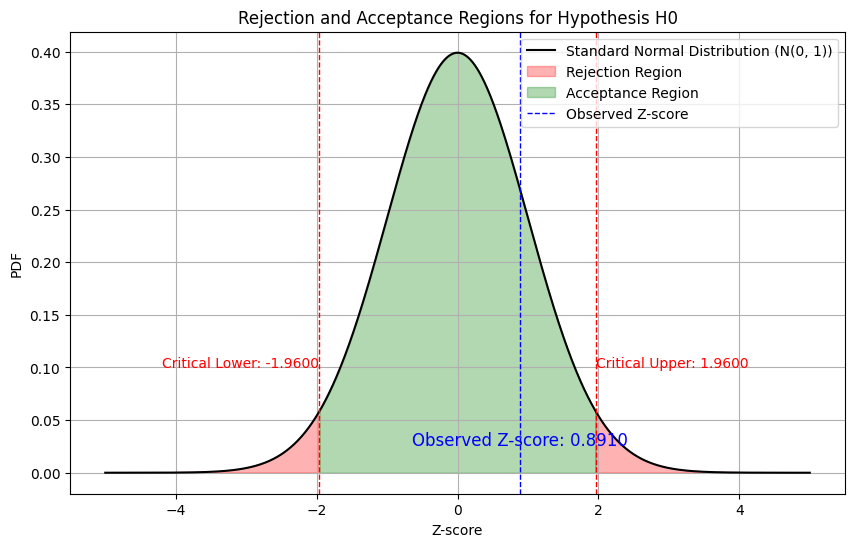

In [86]:
def plot_rejection_regions(result):
    plt.figure(figsize=(10, 6))

    # Plot normal distribution (N(0, 1))
    x = np.linspace(-5, 5, 1000)
    y = stats.norm.pdf(x)
    plt.plot(x, y, 'k', label='Standard Normal Distribution (N(0, 1))')

    # rejection and acceptance regions
    critical_z_lower = -np.abs(result['critical_z_score'].values[0])
    critical_z_upper = np.abs(result['critical_z_score'].values[0])
    plt.fill_between(x, y, where=(x <= critical_z_lower) | (x >= critical_z_upper), color='red', alpha=0.3, label='Rejection Region')
    plt.fill_between(x, y, where=(x > critical_z_lower) & (x < critical_z_upper), color='green', alpha=0.3, label='Acceptance Region')

    #  observed Z-score
    observed_z = result['observed_z '].values[0]
    plt.axvline(observed_z, color='blue', linestyle='--', linewidth=1, label='Observed Z-score')
    plt.annotate(f'Observed Z-score: {observed_z:.4f}', xy=(observed_z, 0), xytext=(0, 20), textcoords='offset points', ha='center', fontsize=12, color='blue')

    # vertical dashed lines critical z
    plt.axvline(critical_z_lower, color='red', linestyle='--', linewidth=1)
    plt.axvline(critical_z_upper, color='red', linestyle='--', linewidth=1)

    # annotations critical z
    plt.text(critical_z_lower, 0.1, f'Critical Lower: {critical_z_lower:.4f}', color='red', ha='right', fontsize=10)
    plt.text(critical_z_upper, 0.1, f'Critical Upper: {critical_z_upper:.4f}', color='red', ha='left', fontsize=10)

    plt.xlabel('Z-score')
    plt.ylabel('PDF')
    plt.title('Rejection and Acceptance Regions for Hypothesis H0')
    plt.legend()
    plt.grid(True)
    plt.show()

# call func
plot_rejection_regions(result)


**Recommendation**

With the above result of 2 Testings, we **should not** move the gate from level 30 to level 40.